# Get Huggingface Data

In [1]:
# install Huggingface datasets
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [10]:
##################################################
# EITAN
# This is the first piece of code you need to connect to the pubmed_qa data
# for multiple choice medical questions, where NOTA can be added.
#
##################################################

# Acquire the PubMedQA Data
# Source:
# https://huggingface.co/datasets/bigbio/pubmed_qa

from datasets import load_dataset

pqal0 = load_dataset("bigbio/pubmed_qa", "pubmed_qa_labeled_fold0_source")
train_data = pqal0['train']

# see example
train_data[0]

{'QUESTION': 'Does histologic chorioamnionitis correspond to clinical chorioamnionitis?',
 'CONTEXTS': ['To evaluate the degree to which histologic chorioamnionitis, a frequent finding in placentas submitted for histopathologic evaluation, correlates with clinical indicators of infection in the mother.',
  'A retrospective review was performed on 52 cases with a histologic diagnosis of acute chorioamnionitis from 2,051 deliveries at University Hospital, Newark, from January 2003 to July 2003. Third-trimester placentas without histologic chorioamnionitis (n = 52) served as controls. Cases and controls were selected sequentially. Maternal medical records were reviewed for indicators of maternal infection.',
  'Histologic chorioamnionitis was significantly associated with the usage of antibiotics (p = 0.0095) and a higher mean white blood cell count (p = 0.018). The presence of 1 or more clinical indicators was significantly associated with the presence of histologic chorioamnionitis (p =

## Preprocess data

Aappending contexts to question

In [11]:
##################################################
#
# Eitan: ... and this
#
##################################################


def prepare_pubmed_data(train_data, sample_size=100):
    """
    Prepare PubMedQA data for Goodfire analysis
    """
    # Separate data by answer type
    yes_examples = []
    no_examples = []
    maybe_examples = []

    for example in train_data:

        combined_context = ' '.join(example['CONTEXTS'])
        combined_question = example['QUESTION']+". Review the following context and answer with a single word from this list: ['Yes', 'No', 'Maybe']. "

        msg = [
            {
                "role": "user",
                "content": f"Question: {combined_question}\nContext: {combined_context}"
            },
            {
                "role": "assistant",
                "content": example['final_decision']
            }
        ]

        if example['final_decision'].lower() == 'yes':
            yes_examples.append(msg)

        elif example['final_decision'].lower() == 'no':
            no_examples.append(msg)

        else:  # maybe
            maybe_examples.append(msg)

    # Trim to sample size
    yes_examples   = yes_examples[:sample_size]
    no_examples    = no_examples[:sample_size]
    maybe_examples = maybe_examples[:sample_size]

    return yes_examples, no_examples, maybe_examples

In [12]:
# Prepare data
sample_size = 100
print("Preparing data...")
yes_examples, no_examples, maybe_examples = prepare_pubmed_data(train_data, sample_size)

# view example
yes_examples[0]

Preparing data...


[{'role': 'user',
  'content': "Question: Does histologic chorioamnionitis correspond to clinical chorioamnionitis?. Review the following context and answer with a single word from this list: ['Yes', 'No', 'Maybe']. \nContext: To evaluate the degree to which histologic chorioamnionitis, a frequent finding in placentas submitted for histopathologic evaluation, correlates with clinical indicators of infection in the mother. A retrospective review was performed on 52 cases with a histologic diagnosis of acute chorioamnionitis from 2,051 deliveries at University Hospital, Newark, from January 2003 to July 2003. Third-trimester placentas without histologic chorioamnionitis (n = 52) served as controls. Cases and controls were selected sequentially. Maternal medical records were reviewed for indicators of maternal infection. Histologic chorioamnionitis was significantly associated with the usage of antibiotics (p = 0.0095) and a higher mean white blood cell count (p = 0.018). The presence of 

In [4]:
print(len(yes_examples))
print(len(no_examples))

100
100


# Get Goodfire


In [10]:
##################################################
#
# Eithan, you don't need the rest of this...
# Its the classifier built my way, but ignore it, we'll use the standard code
#
##################################################


!pip install goodfire

## Extract features using Goodfire API

submit pubmedqa prompts, get top_k features.

Using top_k = 50, as per example at: https://docs.goodfire.ai/examples/decision_trees.html

In [8]:
import goodfire

def contrasting_features_yesno(client, variant, yes_examples, no_examples):
    """
    Use Goodfire to extract contrasting features between different answer types
    """
    print("Computing features for yes vs no...")
    yes_no_features, _ = client.features.contrast(
        dataset_1=yes_examples[0:63],
        dataset_2=no_examples[0:63],
        # dataset_1_feature_rerank_query="medical findings supporting yes",
        # dataset_2_feature_rerank_query="medical findings supporting no",
        model=variant,
        top_k=50
    )
    yes_no_features_reranked = client.features.rerank(
    features=yes_no_features,
    query="funny",
    model=variant,
    top_k=50
)
    
    return yes_no_features_reranked

def contrasting_features_yesmaybe(client, variant, yes_examples, maybe_examples):
    """
    Use Goodfire to extract contrasting features between different answer types
    """
    # NOTE:

    print("Computing features for yes vs maybe...")
    yes_maybe_features, _ = client.features.contrast(
        dataset_1=yes_examples,
        dataset_2=maybe_examples,
        dataset_1_feature_rerank_query="clear medical evidence",
        dataset_2_feature_rerank_query="uncertain medical evidence",
        model=variant,
        top_k=50
    )
    return yes_maybe_features

In [13]:
# from google.colab import userdata
import os

# Get API key
api_key = os.getenv('GOODFIRE_API_KEY')

# Initialize Goodfire
client  = goodfire.Client(api_key)
variant = goodfire.Variant("meta-llama/Meta-Llama-3.1-8B-Instruct")

# Extract features
print("Extracting features...")
features = contrasting_features_yesno(client, variant, yes_examples, no_examples)

Extracting features...
Computing features for yes vs no...


In [14]:
len(features)

43

In [15]:
import pickle 

def save_feature_activations(name: str, feature_activations):
  with open(f"{name}.pkl", "wb") as f:
      pickle.dump(feature_activations, f)
      
save_feature_activations('features', features)

In [33]:
# from concurrent.futures import ThreadPoolExecutor
# import tqdm

# def get_feature_activations(client, variant, examples, features, k=50):
#     """
#     Get feature activations for a set of examples using Goodfire
#     """
#     samples = []

#     with ThreadPoolExecutor(max_workers=3) as executor:
#         futures_list = []

#         for example in examples:
#             futures_list.append(
#                 executor.submit(
#                     client.features.inspect,
#                     example,
#                     model=variant,
#                     features=features,
#                 )
#             )

#         for future in tqdm.tqdm(futures_list):
#             context = future.result()
#             features = context.top(k=k)
#             samples.append(features)

#     return samples

In [5]:
import asyncio
import tqdm
from concurrent.futures import ThreadPoolExecutor

def run_in_thread(func, *args, **kwargs):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    # Call the function directly if it's not async
    result = func(*args, **kwargs)

    loop.close()
    return result

def get_feature_activations(client, variant, examples, features, k=50):
    """
    Get feature activations for a set of examples using Goodfire with run_in_thread
    """
    samples = []

    with ThreadPoolExecutor(max_workers=3) as executor:
        futures_list = []

        for example in examples:
            futures_list.append(
                executor.submit(
                    run_in_thread,
                    client.features.inspect,  # Async function
                    example,
                    model=variant,
                    features=features,
                )
            )

        for future in tqdm.tqdm(futures_list, desc="Fetching Features"):
            context = future.result()
            features = context.top(k=k)
            samples.append(features)

    return samples

In [64]:
# Get feature activations for each class
print("Computing feature activations...")

yes_activations   = get_feature_activations(client, variant, yes_examples, features)
no_activations    = get_feature_activations(client, variant, no_examples, features)
# maybe_activations = get_feature_activations(client, variant, maybe_examples, features)

Computing feature activations...


Fetching Features: 100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


In [ ]:
yes_activations

In [66]:
import pickle

# Save the data to a file
def save_feature_activations(name: str, feature_activations):
  with open(f"{name}.pkl", "wb") as f:
      pickle.dump(feature_activations, f)


save_feature_activations("yes_activations", yes_activations)
save_feature_activations("no_activations", no_activations)

In [1]:
import pickle 

def load_feature_activations(name: str):
  with open(f"{name}.pkl", "rb") as f:
      activations = pickle.load(f)
  return activations

features = load_feature_activations('features')

In [2]:
import pickle
# Load the data from a file
def load_feature_activations(name: str):
  with open(f"{name}.pkl", "rb") as f:
      activations = pickle.load(f)
  return activations

activations_no = load_feature_activations('yes_activations')
activations_yes = load_feature_activations('no_activations')

In [3]:
activations_yes

[FeatureActivations(
    0: (Feature("Explanatory and causal language patterns in step-by-step reasoning"), 256)
    1: (Feature("Anatomical spatial relationships and positioning"), 42)
    2: (Feature("Laboratory animal experimental procedures and protocols"), 35)
    3: (Feature("Detailed surgical procedure descriptions in medical documentation"), 24)
    4: (Feature("Medical treatment protocols and medication administration details"), 20)
    5: (Feature("Scientific methodology and analysis description in research papers"), 17)
    6: (Feature("Abstract nouns describing scientific processes and mechanisms"), 11)
    7: (Feature("Control groups and baseline comparisons in experimental contexts"), 11)
    8: (Feature("Collection and processing of biological samples for medical testing"), 10)
    9: (Feature("Gastrointestinal endoscopy procedures and findings"), 7)
    ...
    49: (Feature("The Russian word состав (composition/compilation) and its variations"), 0)
 ),
 FeatureActivatio

In [4]:
def prepare_feature_matrix(feature_activations, features):
    """
    Convert feature activations into a matrix for training
    """
    def _select_feature_acts(features, row):
        output = []
        for feature in features:
            found = False
            for feature_act in row:
                if feature_act.feature.uuid == feature.uuid:
                    output.append(feature_act.activation)
                    found = True
                    break
            if not found:
                output.append(0.0)  # Default value if feature not found
        return output

    X = [_select_feature_acts(features, row) for row in feature_activations]
    return X

In [5]:
X_yes = prepare_feature_matrix(activations_yes, features)
X_no = prepare_feature_matrix(activations_no, features)
# X_maybe = prepare_feature_matrix(maybe_activations, features)

# view example, we expect 50 features
print("Length of X_yes = ", len(X_yes))
print("Length of X_no  = ", len(X_no))
print("Example of X_yes:\n ", X_yes[0])

Length of X_yes =  100
Length of X_no  =  100
Example of X_yes:
  [0, 0, 3, 0, 1, 0, 1, 11, 256, 0, 0, 11, 1, 0, 0, 42, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 1, 0, 7, 24, 0, 1, 17, 0, 35, 0, 0, 1, 0, 0, 10, 0, 20]


# Compressibility

We have 100 samples of yes and 100 no, but 50 predictors. Could overfit.

What is compressibility of this data?



In [6]:
import numpy as np
from typing import List, Dict, Tuple, NamedTuple
from dataclasses import dataclass

class DatasetStats(NamedTuple):
  position_variances: np.ndarray  # Variance at each position across all examples
  top_variant_positions: List[int]  # Indices of positions with highest variance
  position_activity: np.ndarray  # Percentage of non-zero values at each position
  mean_vector: np.ndarray  # Mean value at each position
  std_vector: np.ndarray  # Standard deviation at each position
  sparsity: float  # Overall sparsity of the dataset

def analyze_datasets(examples, n_top_positions = 5):
  """
  Analyze multiple examples simultaneously to find the most variant positions.

  Args:
      examples: List of examples, where each example is a list of float values
      n_top_positions: Number of top variant positions to identify

  Returns:
      DatasetStats containing analysis results
  """
  # Convert to numpy array for efficient computation
  data = np.array(examples)

  # Calculate variance at each position
  position_variances = np.var(data, axis=0)

  # Get indices of positions with highest variance
  top_variant_positions = np.argsort(position_variances)[-n_top_positions:].tolist()[::-1]

  # Calculate percentage of non-zero values at each position
  position_activity = np.mean(data != 0, axis=0) * 100

  # Calculate mean and std at each position
  mean_vector = np.mean(data, axis=0)
  std_vector = np.std(data, axis=0)

  # Calculate overall sparsity
  sparsity = np.mean(data == 0) * 100

  return DatasetStats(
      position_variances=position_variances,
      top_variant_positions=top_variant_positions,
      position_activity=position_activity,
      mean_vector=mean_vector,
      std_vector=std_vector,
      sparsity=sparsity
  )

def print_analysis_report(stats: DatasetStats, n_positions: int = 5):
  """
  Print a comprehensive analysis report.

  Args:
      stats: DatasetStats object containing analysis results
      n_positions: Number of top positions to show in detail
  """
  print(f"Dataset Analysis Report")
  print("=" * 50)
  print(f"\nOverall Statistics:")
  print(f"Sparsity: {stats.sparsity:.2f}% zeros")

  print(f"\nTop {n_positions} Most Variant Positions:")
  print("-" * 50)
  print(f"{'Position':^10} {'Variance':^12} {'Activity%':^12} {'Mean':^12} {'Std':^12}")
  print("-" * 50)

  for pos in stats.top_variant_positions[:n_positions]:
      print(f"{pos:^10} {stats.position_variances[pos]:^12.4f} "
            f"{stats.position_activity[pos]:^12.2f} "
            f"{stats.mean_vector[pos]:^12.4f} "
            f"{stats.std_vector[pos]:^12.4f}")

In [7]:
# Combine Data, predictors (x) and targets (y)
import random

print(f"There are {len(X_yes)} examples for 'Yes'")
print(f"There are {len(X_no)} examples for 'No'")

X = X_yes + X_no #+ X_maybe
y = ([1] * len(X_yes)) + ([0] * len(X_no))  # yes=1, no=0
#y = ([2] * len(X_yes)) + ([0] * len(X_no)) + ([1] * len(X_maybe))  # yes=2, no=0, maybe=1
assert len(X) == len(y)

print("Therefore...")
print("Total length of X:", len(X))
print("Total length of y:", len(y))
print("\n")

# Let's view a random sample
indices = random.sample(range(len(X)), 3)
print("Some random examples")
for i in indices:
  print(f"Element {i}:")
  print("   X:", X[i])
  print("   y:", y[i])


There are 100 examples for 'Yes'
There are 100 examples for 'No'
Therefore...
Total length of X: 200
Total length of y: 200


Some random examples
Element 130:
   X: [0, 0, 2, 0, 4, 0, 2, 25, 115, 0, 0, 29, 3, 0, 0, 2, 76, 0, 1, 0, 3, 0, 1, 0, 0, 4, 0, 0, 0, 0, 2, 0, 27, 0, 27, 1, 0, 4, 0, 0, 0, 0, 3]
   y: 0
Element 17:
   X: [0, 0, 7, 0, 3, 0, 0, 18, 8, 0, 0, 4, 20, 0, 0, 3, 0, 0, 0, 1, 0, 0, 5, 1, 0, 0, 0, 0, 0, 122, 0, 11, 21, 0, 14, 0, 0, 22, 0, 0, 10, 0, 6]
   y: 1
Element 107:
   X: [0, 0, 3, 0, 4, 0, 9, 31, 133, 0, 14, 30, 7, 0, 0, 6, 1, 6, 0, 13, 0, 0, 4, 77, 0, 3, 7, 42, 0, 26, 202, 0, 51, 0, 32, 0, 27, 0, 0, 0, 4, 1, 20]
   y: 0


In [8]:

# Analyse compressibility
n_top_positions = 10
stats = analyze_datasets(X, n_top_positions)
print_analysis_report(stats, n_top_positions)

Dataset Analysis Report

Overall Statistics:
Sparsity: 54.42% zeros

Top 10 Most Variant Positions:
--------------------------------------------------
 Position    Variance    Activity%       Mean         Std     
--------------------------------------------------
    8       5712.3775      98.00       74.8500      75.5803   
    29      1832.9699      53.00       20.4900      42.8132   
    30      1684.3484      63.00       24.0400      41.0408   
    34      1357.4151      99.00       42.5700      36.8431   
    42      1135.3488      83.00       28.2150      33.6949   
    38      1038.8619      32.00       10.5900      32.2314   
    23       843.2764      62.00       13.4400      29.0392   
    12       831.9375      56.50       13.2500      28.8433   
    35       824.7556      25.00        5.8800      28.7186   
    10       671.5948      39.00        8.0150      25.9151   


In [9]:
# get important locations in data
X_compressed = [[x[i] for i in stats.top_variant_positions[0:1]] for x in X]

# view example
print("X:\n", X_compressed[0])
print("Y:\n", y[0])


X:
 [256]
Y:
 1


In [18]:
import numpy as np
X_compressed = np.array(X_compressed)
print(X_compressed.shape)

(200, 1)


## Train the Decision Tree

For speed we'll sub divide the training set into train and test, then I can use objects already created...

Lazy, I know, but in a hurry here...and justtrying to explore the territory...

In [25]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score
import pandas as pd

def train_tree(X, y, depth):
    """
    Train a decision tree classifier
    """
    train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=42)

    model = tree.DecisionTreeClassifier(
        max_depth=depth,
        min_samples_leaf=len(train_x) // 20,
        random_state=42
    )

    model.fit(train_x, train_y)
    pred = model.predict(test_x)

    accuracy = balanced_accuracy_score(test_y, pred)
    score = f1_score(test_y, pred, average='weighted')

    return model, pred, score, accuracy, (train_x, test_x, train_y, test_y)

In [26]:
import numpy as np
X = np.array(X)
print(X.shape)

(200, 43)


In [29]:
# Train model on original data
print("Training decision tree...")
model, pred, score, accuracy, splits = train_tree(X, y, depth=3)

print(f"Balanced Accuracy: {accuracy:.3f}")
print(f"F1 Score: {score:.3f}")

Training decision tree...
Balanced Accuracy: 0.855
F1 Score: 0.849


In [28]:
# Train model on compressed data
print("Training decision tree...")
model_comp, pred, score, accuracy, splits = train_tree(X_compressed, y, depth=3)

print(f"Balanced Accuracy: {accuracy:.3f}")
print(f"F1 Score: {score:.3f}")

Training decision tree...
Balanced Accuracy: 0.584
F1 Score: 0.552


## Visualise

As per goodfire example

In [31]:
# Create visualisation
import graphviz

feature_names = [feature.label for feature in features]
dot_data = tree.export_graphviz(
    model,
    out_file=None,
    feature_names=feature_names,
    class_names=['no', 'maybe', 'yes'],
    filled=True,
    rounded=True,
    special_characters=True
)
viz = graphviz.Source(dot_data)
viz.render("decision_tree")

'decision_tree.pdf'

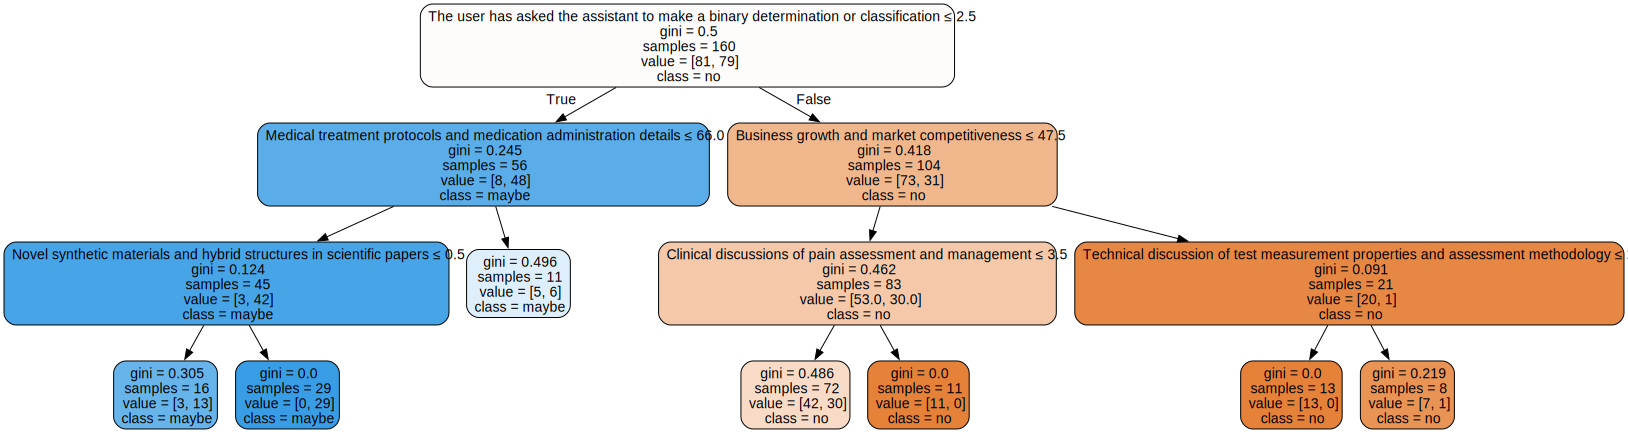

In [32]:
viz